<h1>Jigsaw Unintended Bias in Toxicity Classification</h1>

<h4>This is a continuation code to the part_1 file(where we performed EDA, Text preprocessing and Feature engineering).

Now in this file we will do modeling,training and testing</h4>   

In [2]:
#For Data loading and preprocessing
import pandas as pd

#For matrix operations
import numpy as np

#For plotting
import matplotlib.pyplot as plt
import seaborn as sns

#For splitting the data
from sklearn.model_selection import train_test_split


#For data preprocessing
from sklearn.preprocessing import StandardScaler,MinMaxScaler,normalize

#For hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

#For appling models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm  import LinearSVC
from sklearn.naive_bayes import MultinomialNB

#For model persistence 
from sklearn.externals import joblib

#For text vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer


#For math operations
import math 

#To see the progress of the iterations
from tqdm import tqdm

#Performance metrices
from sklearn import metrics
from sklearn.metrics import roc_auc_score,roc_curve,auc,log_loss,confusion_matrix,make_scorer

from scipy.sparse import hstack

#
from datetime import datetime

#For ignoring warnings
import warnings
warnings.filterwarnings("ignore")



/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#Importing prepared data for modeling
data = pd.read_csv("data_processed.csv")
data.head()


,target,severe_toxicity,obscene,threat,insult,identity_attack,sexual_explicit,male,female,homosexual_gay_or_lesbian,...,preprocessed_reviews,word_count,comment_length,num_bad_words,len_bad_words,profinity_frequency,profinity_len_frequency,profinity_mul,profinity_sum,profinity_HM
0,0,0,0,0,0,0,0,0,0,0,...,cool like would want mother read really great ...,11,60,0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,thank would make life lot less anxiety inducin...,14,75,0,0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,urgent design problem kudos taking impressive,6,45,0,0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,something able install site releasing,5,37,0,0,0.0,0.0,0.0,0.0,0.0
4,1,0,0,0,1,0,0,0,0,0,...,haha guys bunch losers,4,22,0,0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Taking all input features into X variable
X = data[['preprocessed_reviews',
 'word_count',
 'comment_length',
 'num_bad_words',
 'len_bad_words',
 'profinity_frequency',
 'profinity_len_frequency',
 'profinity_mul',
 'profinity_sum',
 'profinity_HM']]

In [5]:
#Taking all output class labels to Y 
Y = data[['target',
 'severe_toxicity',
 'obscene',
 'threat',
 'insult',
 'identity_attack',
 'sexual_explicit',
 'male',
 'female',
 'homosexual_gay_or_lesbian',
 'christian',
 'jewish',
 'muslim',
 'black',
 'white',
 'psychiatric_or_mental_illness']]

ALL_labels= Y.columns.to_list()

final_auc = 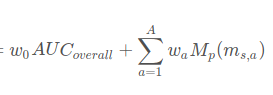

In [6]:
# Defing own AUC based metric,specially mentioned for this competition
# This code was inspired from :https://www.kaggle.com/kenkrige/subgroup-analysis

def AUC(df_y):

    fpr, tpr, thresholds = roc_curve(df_y["actual"],df_y["predict"])
    return auc(fpr, tpr)

def Mp(data, p=-5.0):
    return np.average(data.astype(float) ** p) ** (1/p)


def final_AUC_metric(y_true, y_predicted,final_AUC_metric_alone=True):

    
    y_true= pd.DataFrame(y_true, columns=ALL_labels).reset_index(drop=True)  #Converting Actual output arrays to dataframes with same labels  
    y_predicted= pd.DataFrame(y_predicted, columns=ALL_labels).reset_index(drop=True) #Converting Predicted output arrays to dataframes with same labels  
    
    y_df = pd.DataFrame(y_true['target'].to_list(), columns=["actual"]) #putting only ['target'] values of both "y_true" and "y_predicted" into single DF
    y_df["predict"]=y_predicted['target'].to_list()
    
    IDENTITY_labels = ["male",
                       "female",
                       "homosexual_gay_or_lesbian",
                       "christian",
                       "jewish",
                       "muslim",
                       "black",
                       "white",
                       "psychiatric_or_mental_illness"]
    
    results = pd.DataFrame(columns = ['SUB', 'BPSN', 'BNSP'], index = IDENTITY_labels) # Created to collect all AUCs
    
    overall = AUC(df_y=y_df)  #This overall AUC (diretly between (y_true['target'],y_predicted['target']  )
    
    for label in IDENTITY_labels: # Calculating BPSN and BNSP for each identity label 
        y_true[label] = y_true[label] == 1
        y_true['target'] = y_true['target']==1
        
        bpsn = y_true[label]^y_true['target']    
        bnsp = ~(y_true[label]^y_true['target'])
        
        results.loc[label,'BPSN']= AUC(df_y = y_df[bpsn]) 
        results.loc[label,'BNSP']= AUC(df_y = y_df[bnsp])
        results.loc[label,'SUB']=  AUC(df_y = y_df[y_true[label]])

    results.loc['Mp',:] = results.apply(Mp, axis= 0)

    

    final_auc = ((results.loc['Mp',:].sum()) + overall) / 4

    if final_AUC_metric_alone:
        return final_auc
    else:
        return final_auc, results
#final_AUC = make_scorer(final_AUC_metric, greater_is_better=True,final_AUC_metric_alone=True)

#### Before solving let's try to understand the way to train the model for this data.

#### Since we have 16 labels as output let's try solving this by employing simple Multi-label classification method, and observe the results.

#### Method-1

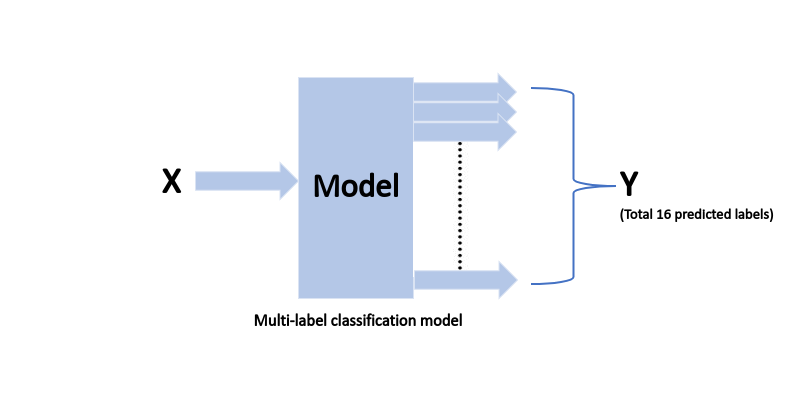

In [7]:
#Splitting the data into train,CV and Test
X_train, X_test, y_train, y_test =train_test_split(X, Y,test_size=0.30, shuffle=False)
X_train, X_cv, y_train, y_cv =train_test_split(X_train,y_train,test_size=0.30, shuffle=False)

In [8]:
#Vectorizing the text using TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=6000,ngram_range=(1,2))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['preprocessed_reviews'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['preprocessed_reviews'])
X_cv_tfidf = tfidf_vectorizer.transform(X_cv['preprocessed_reviews'])


X_train_tfidf = normalize(X_train_tfidf,axis=0)
X_test_tfidf = normalize(X_test_tfidf,axis=0)
X_cv_tfidf = normalize(X_cv_tfidf,axis=0)


In [9]:
#Vectorizing the text using BOW
bow_vectorizer = CountVectorizer(max_features=6000,ngram_range=(1,2))
X_train_bow = bow_vectorizer.fit_transform(X_train['preprocessed_reviews'])
X_test_bow = bow_vectorizer.transform(X_test['preprocessed_reviews'])
X_cv_bow = bow_vectorizer.transform(X_cv['preprocessed_reviews'])

X_train_bow = normalize(X_train_bow,axis=0)
X_test_bow = normalize(X_test_bow,axis=0)
X_cv_bow = normalize(X_cv_bow,axis=0)

In [10]:
#Once after vectorizing the text we donot need "preprocessed_reviews" column, hence droping the same
X_train =X_train.drop(columns=["preprocessed_reviews"])
X_test =X_test.drop(columns=["preprocessed_reviews"])
X_cv =X_cv.drop(columns=["preprocessed_reviews"])

In [11]:
#Maintaing the same scale 
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)
X_cv = scale.transform(X_cv)

In [12]:
X_train_TFIDF = hstack ([(X_train_tfidf),(X_train)])
X_test_TFIDF = hstack ([(X_test_tfidf),(X_test)])
X_cv_TFIDF = hstack ([(X_cv_tfidf),(X_cv)])

X_train_BOW = hstack ([(X_train_bow),(X_train)])
X_test_BOW = hstack ([(X_test_bow),(X_test)])
X_cv_BOW = hstack ([(X_cv_bow),(X_cv)])


In [20]:
def tune_ML_clf(clf,x_train,x_cv,clf_name):
    start = datetime.now()
    if clf_name=="NavieBayes":
        parameters = {'estimator__alpha':[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10]}
    else:    
        parameters = {'estimator__alpha':[0.01,0.1,1,10,100,1000,10000,100000,100000,1000000]}
    cv_value = []
    train_auc= []

    #clf = GridSearchCV(classifier,param_grid=parameters, cv=5,scoring=final_AUC, n_jobs=-1)

    for param in tqdm(parameters["estimator__alpha"]):
        if clf_name=="NavieBayes":
            classifier = OneVsRestClassifier(clf(alpha=param), n_jobs=-1)
        else:   
            classifier = OneVsRestClassifier(clf(C=param,class_weight='balanced'),n_jobs=-1)
        classifier.fit(x_train,y_train)
        y_train_pred =  classifier.predict(x_train)
        y_cv_pred =  classifier.predict(x_cv)
        train_auc.append(final_AUC_metric(y_true=y_train,y_predicted=y_train_pred,final_AUC_metric_alone=True))
        cv_value.append(final_AUC_metric(y_true=y_cv,y_predicted=y_cv_pred,final_AUC_metric_alone=True))
    log_s= [math.log(i) for i in parameters["estimator__alpha"]]
    fig = plt.figure()
    plt.grid()    
    plt.plot(log_s, train_auc, label='Train Final-AUC')
    plt.plot(log_s, cv_value, label='CV Final-AUC')
    plt.legend()
    plt.xlabel("Hyperparameter")
    plt.ylabel("Final Toxic-AUC")
    plt.title("{} finalToxic-AUC plot for Train and Validation data".format(clf_name))
    #plt.show()
    return fig
    
def fit_best_ML_clf(clf,x_train,x_test):
        classifier = OneVsRestClassifier(clf, n_jobs=-1)
        classifier.fit(x_train,y_train)
        y_train_pred =  classifier.predict(x_train)
        y_test_pred =  classifier.predict(x_test)
        return final_AUC_metric(y_true=y_test,y_predicted=y_test_pred,final_AUC_metric_alone=False)

#### For all the below models first I performed hyperparameter tuning and then training with the best parameters.

### ML Classifers trying with BOW vectorizer 

### 1.NavieBayes 

100%|██████████| 9/9 [15:58<00:00, 107.28s/it]


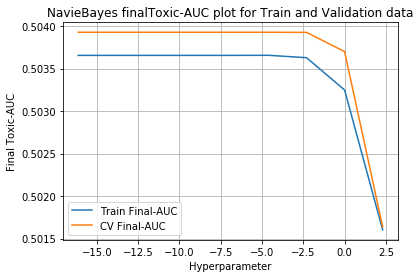

In [44]:
NavieBayes_tuning_BOW= tune_ML_clf(clf=MultinomialNB,x_train=X_train_BOW,x_cv=X_cv_BOW,clf_name='NavieBayes')

In [54]:
results_NB_BOW= fit_best_ML_clf(clf=MultinomialNB(alpha=0.000000000000001),x_train=X_train_BOW,x_test=X_test_BOW)

In [55]:
print('AUCs of all identity lables\n')
print(results_NB_BOW[1])
print("\nFinal-AUC on test data is {}".format(results_NB_BOW[0]))

AUCs of all identity lables

                                    SUB      BPSN      BNSP
male                           0.500494  0.506635  0.500021
female                         0.500366  0.506744  0.499793
homosexual_gay_or_lesbian      0.500556  0.505265  0.501275
christian                      0.501246  0.506525   0.50071
jewish                              0.5  0.506553  0.499371
muslim                         0.501757  0.506454  0.501278
black                          0.500686  0.506787  0.500054
white                          0.500751  0.506943  0.500114
psychiatric_or_mental_illness   0.50101  0.506116  0.500805
Mp                             0.500761  0.506446  0.500378

Final-AUC on test data is 0.5033646305327918


### 2. Logistic Regression

100%|██████████| 10/10 [1:07:35<00:00, 537.01s/it]


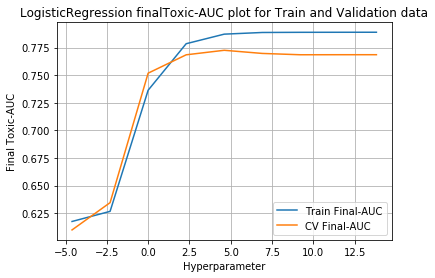

In [45]:
LR_tuning_BOW = tune_ML_clf(clf=LogisticRegression,x_train=X_train_BOW,x_cv=X_cv_BOW,clf_name='LogisticRegression')

In [56]:
results_LR_BOW= fit_best_ML_clf(clf=LogisticRegression(C=100000),x_train=X_train_BOW,x_test=X_test_BOW)

In [57]:
print('AUCs of all identity lables\n')
print(results_LR_BOW[1])
print("\nFinal-AUC on test data is {}".format(results_LR_BOW[0]))

AUCs of all identity lables

                                    SUB      BPSN      BNSP
male                           0.677892  0.697633  0.691121
female                         0.681812  0.701089  0.691523
homosexual_gay_or_lesbian      0.623411  0.687451  0.647108
christian                      0.656697  0.706667   0.66088
jewish                         0.667283  0.683856  0.693218
muslim                           0.6564  0.664369  0.702087
black                           0.64031  0.678894   0.67309
white                          0.649496  0.684217    0.6778
psychiatric_or_mental_illness  0.660042  0.691266  0.678624
Mp                             0.655669  0.687745  0.678267

Final-AUC on test data is 0.6828125070476742


### 3. Support Vector Machine

In [ ]:
SVM_tuning_BOW= tune_ML_clf(clf=LinearSVC,x_train=X_train_BOW,x_cv=X_cv_BOW,clf_name='SupportVetor')

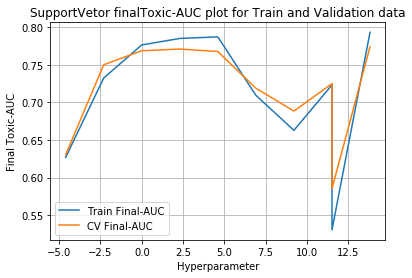

In [50]:
SVM_tuning_BOW

In [58]:
results_SVM_BOW= fit_best_ML_clf(clf=LinearSVC(C=10000),x_train=X_train_BOW,x_test=X_test_BOW)

In [59]:
print('AUCs of all identity lables\n')
print(results_SVM_BOW[1])
print("\nFinal-AUC on test data is {}".format(results_SVM_BOW[0]))

AUCs of all identity lables

                                    SUB      BPSN      BNSP
male                           0.670842  0.701154   0.68174
female                         0.671988  0.704531  0.679579
homosexual_gay_or_lesbian      0.623703  0.688845  0.646757
christian                      0.646239  0.708793  0.649304
jewish                          0.64999  0.691301  0.669387
muslim                         0.647426  0.676512  0.682102
black                          0.630746  0.685085  0.658764
white                           0.64195  0.692213  0.663997
psychiatric_or_mental_illness  0.651632  0.697899   0.66441
Mp                             0.647237  0.693641  0.665517

Final-AUC on test data is 0.6791733826499673


### ML Classifers trying with TFIDF vectorizer

### NavieBayes

In [ ]:
NavieBayes_tuning_TFIDF= tune_ML_clf(clf=MultinomialNB,x_train=X_train_TFIDF,x_cv=X_cv_TFIDF,clf_name='NavieBayes')

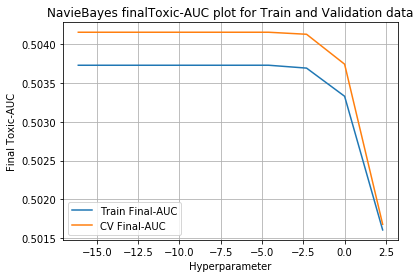

In [51]:
NavieBayes_tuning_TFIDF

In [60]:
results_NB_TFIDF=fit_best_ML_clf(clf=MultinomialNB(alpha=0.000001),x_train=X_train_TFIDF,x_test=X_test_TFIDF)

In [61]:
print('AUCs of all identity lables\n')
print(results_NB_TFIDF[1])
print("\nFinal-AUC on test data is {}".format(results_NB_TFIDF[0]))

AUCs of all identity lables

                                    SUB      BPSN      BNSP
male                           0.500452  0.506798  0.500053
female                         0.500366  0.506948  0.499825
homosexual_gay_or_lesbian      0.500556  0.505464  0.501306
christian                      0.501246  0.506723  0.500742
jewish                              0.5  0.506748  0.499402
muslim                         0.501757  0.506653  0.501309
black                          0.500686   0.50699  0.500085
white                          0.500751  0.507152  0.500145
psychiatric_or_mental_illness   0.50101  0.506311  0.500836
Mp                             0.500757  0.506642  0.500409

Final-AUC on test data is 0.5034763499902504


### Logistic Regression

In [ ]:
LR_tuning_TFIDF= tune_ML_clf(clf=LogisticRegression,x_train=X_train_TFIDF,x_cv=X_cv_TFIDF,clf_name='LogisticRegression')

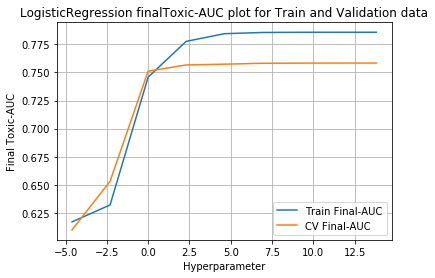

In [52]:
LR_tuning_TFIDF

In [62]:
results_LR_TFIDF=fit_best_ML_clf(clf=LogisticRegression(C=100000),x_train=X_train_TFIDF,x_test=X_test_TFIDF)

In [63]:
print('AUCs of all identity lables\n')
print(results_LR_TFIDF[1])
print("\nFinal-AUC on test data is {}".format(results_LR_TFIDF[0]))


AUCs of all identity lables

                                    SUB      BPSN      BNSP
male                           0.718399  0.724379  0.740597
female                         0.721663  0.727315  0.740921
homosexual_gay_or_lesbian       0.65908  0.698101   0.70786
christian                      0.708194  0.738483  0.716336
jewish                         0.709201  0.694249  0.760741
muslim                         0.709101  0.647256  0.806845
black                          0.679795  0.696115  0.730634
white                          0.685955  0.699753  0.733711
psychiatric_or_mental_illness  0.736731  0.703425  0.778893
Mp                              0.70086  0.700392  0.743028

Final-AUC on test data is 0.7225040328825973


### Support Vector Machine

In [ ]:
SVM_tuning_TFIDF= tune_ML_clf(clf=LinearSVC,x_train=X_train_TFIDF,x_cv=X_cv_TFIDF,clf_name='SupportVetor')

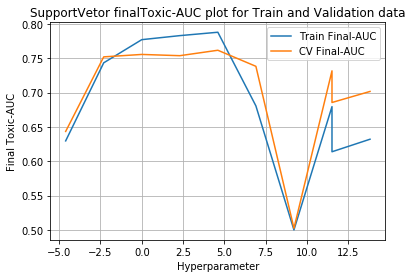

In [53]:
SVM_tuning_TFIDF

In [64]:
results_SVM_TFIDF=fit_best_ML_clf(clf=LinearSVC(C=100000),x_train=X_train_TFIDF,x_test=X_test_TFIDF)

In [65]:
print('AUCs of all identity lables\n')
print(results_SVM_TFIDF[1])
print("\nFinal-AUC on test data is {}".format(results_SVM_TFIDF[0]))


AUCs of all identity lables

                                    SUB      BPSN      BNSP
male                           0.650164  0.683959  0.658173
female                         0.650172  0.686021  0.656209
homosexual_gay_or_lesbian      0.605652  0.673373  0.624029
christian                      0.620697  0.689531  0.622977
jewish                         0.639467   0.67406  0.655858
muslim                         0.640388  0.660974  0.670195
black                          0.618943  0.672586  0.639177
white                          0.628128  0.679763  0.642413
psychiatric_or_mental_illness  0.649541  0.680232   0.65968
Mp                             0.632564  0.677535  0.646493

Final-AUC on test data is 0.6616772399483662


In [66]:
from prettytable import PrettyTable
conclude = PrettyTable()
clf_set = ['NB',"LR",'SVM','NB',"LR",'SVM']
vetors_set = ['BOW','TFIDF']
results_set1 = [results_NB_BOW,results_LR_BOW,results_SVM_BOW]
results_set2= [results_NB_TFIDF,results_LR_TFIDF,results_SVM_TFIDF]

conclude.field_names = ["Classifier",'Vetorizer',"Test_Final_Toxic_AUC"]

for i,result in enumerate(results_set1):
    conclude.add_row([clf_set[i],vetors_set[0],result[0]])
    
for i,result in enumerate(results_set2):
    conclude.add_row([clf_set[i],vetors_set[1],result[0]])
print(conclude)

+------------+-----------+----------------------+
| Classifier | Vetorizer | Test_Final_Toxic_AUC |
+------------+-----------+----------------------+
|     NB     |    BOW    |  0.5033646305327918  |
|     LR     |    BOW    |  0.6828125070476742  |
|    SVM     |    BOW    |  0.6791733826499673  |
|     NB     |   TFIDF   |  0.5034763499902504  |
|     LR     |   TFIDF   |  0.7225040328825973  |
|    SVM     |   TFIDF   |  0.6616772399483662  |
+------------+-----------+----------------------+


#### On observing the above results, we can conclude that the performance of all these models are not upto the mark. 

### Hence let's try the following method. And see how it is working

#### Method-2

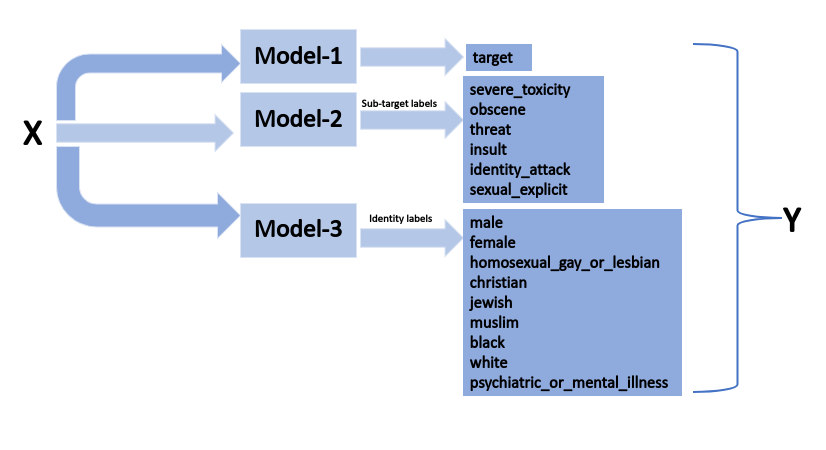

In [64]:
def tune_Models_clf(clf,x_train,x_cv,y_train,y_cv,clf_name,multi_label):
    start = datetime.now()
    if clf_name=="NavieBayes":
        parameters = {'estimator__alpha':[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10]}
    else:    
        parameters = {'estimator__alpha':[0.01,0.1,1,10,100,1000,10000,100000,100000,1000000]}
    cv_value = []
    train_auc= []

    #clf = GridSearchCV(classifier,param_grid=parameters, cv=5,scoring=final_AUC, n_jobs=-1)
    if multi_label==True:
        for param in tqdm(parameters["estimator__alpha"]):
            if clf_name=="NavieBayes":
                classifier = OneVsRestClassifier(clf(alpha=param), n_jobs=-1)
            else:   
                classifier = OneVsRestClassifier(clf(C=param,class_weight='balanced'),n_jobs=-1)
            classifier.fit(x_train,y_train)
            y_train_pred =  classifier.predict(x_train)
            y_cv_pred =  classifier.predict(x_cv)
            train_auc.append(roc_auc_score(y_train, y_train_pred))
            cv_value.append(roc_auc_score(y_cv, y_cv_pred))
    else:
        for param in tqdm(parameters["estimator__alpha"]):
            if clf_name=="NavieBayes":
                classifier = clf(alpha=param)
            else:   
                classifier = clf(C=param,class_weight='balanced')
            classifier.fit(x_train,y_train)
            y_train_pred =  classifier.predict(x_train)
            y_cv_pred =  classifier.predict(x_cv)
            train_auc.append(roc_auc_score(y_train, y_train_pred))
            cv_value.append(roc_auc_score(y_cv, y_cv_pred))

    log_s= [math.log(i) for i in parameters["estimator__alpha"]]
    fig = plt.figure()
    plt.grid()    
    plt.plot(log_s, train_auc, label='Train AUC')
    plt.plot(log_s, cv_value, label='CV AUC')
    plt.legend()
    plt.xlabel("Hyperparameter")
    plt.ylabel("AUC")
    plt.title("{} AUC plot for Train and Validation data".format(clf_name))
    #plt.show()
    return fig
    
def fit_best_Model_clf(clf,x_train,x_test,y_train,y_test,multi_label,return_predictions=False):
    if multi_label ==True:
        classifier = OneVsRestClassifier(clf, n_jobs=-1)
    else:
        classifier = clf
    classifier.fit(x_train,y_train)
    y_train_pred =  classifier.predict(x_train)
    y_test_pred =  classifier.predict(x_test)
    if return_predictions==True:
        return (y_train_pred,y_test_pred)
    return (roc_auc_score(y_train,y_train_pred),roc_auc_score(y_test,y_test_pred))


##  Model1

100%|██████████| 10/10 [11:06<00:00, 94.22s/it]


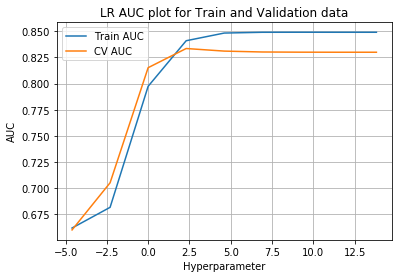

In [28]:
#With LR
model1 = LogisticRegression
model1_LR_hp = tune_Models_clf(clf=model1,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train['target'],
                y_cv=y_cv['target'],
                clf_name="LR",
                multi_label=False)

#### From the above plot we can see there is the best AUC value at log(C)=2, hence choosing C= 100

In [39]:
model1 =LogisticRegression(C=100)
model1_LR = fit_best_Model_clf(clf=model1,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                               y_train=y_train['target'],
                               y_test=y_test['target'],
                               multi_label=False)
print("AUC on Test data using LR as model1: {}".format(model1_LR[1]) )

print("AUC on Train data using LR as model1: {}".format(model1_LR[0]) )

AUC on Test data using LR as model1: 0.828861056809807
AUC on Train data using LR as model1: 0.8695229696127141


100%|██████████| 10/10 [1:15:13<00:00, 536.18s/it]


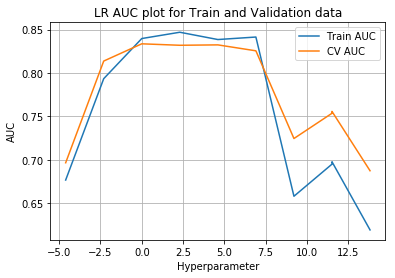

In [31]:
#With SVM
#With LR
model1 = LinearSVC
model1_SVM_hp = tune_Models_clf(clf=model1,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train['target'],
                y_cv=y_cv['target'],
                clf_name="SVM",
                multi_label=False)

#### From the above plot, we can say that at log(C)=0 it has best fit, hence choosing C=1   

In [42]:

model1 =LinearSVC(C=1)
model1_SVM = fit_best_Model_clf(clf=model1,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                               y_train=y_train['target'],
                               y_test=y_test['target'],
                               multi_label=False)
print("AUC on Test data using SVM as model1: {}".format(model1_SVM[1]) )

print("AUC on Train data using SVM as model1: {}".format(model1_SVM[0]) )

AUC on Test data using SVM as model1: 0.8908976247481009
AUC on Train data using SVM as model1: 0.9112955833056791


100%|██████████| 9/9 [01:00<00:00,  6.73s/it]


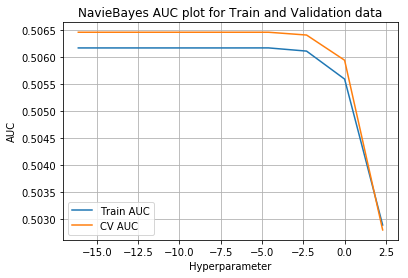

In [32]:
#With MultinomialNB
model1 = MultinomialNB
model1_NB_hp = tune_Models_clf(clf=model1,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train['target'],
                y_cv=y_cv['target'],
                clf_name="NavieBayes",
                multi_label=False)


#### The performance of NB is not at all up to the mark, hence we are not trianing with NB

In [43]:
model1_results= pd.DataFrame(zip([model1_LR[1],model1_SVM[1]],[model1_LR[0],model1_SVM[0]]),
              columns=['Test_AUC','Train_AUC'],index=['LR',"SVM"])
model1_results

,Test_AUC,Train_AUC
LR,0.828861,0.869523
SVM,0.890898,0.911296


### Model-2

100%|██████████| 10/10 [37:38<00:00, 373.52s/it]


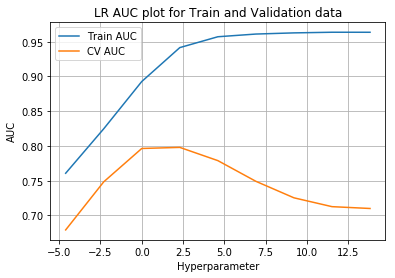

In [33]:
#With LR
model2 = LogisticRegression
model2_LR_hp = tune_Models_clf(clf=model2,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                y_cv=y_cv[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                clf_name="LR",
                multi_label=True)

100%|██████████| 10/10 [1:26:01<00:00, 533.86s/it]


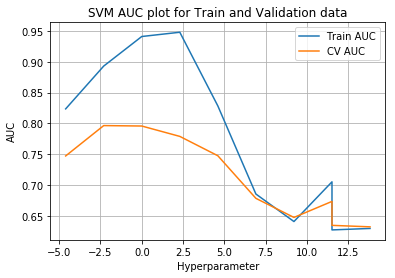

In [34]:
#With SVM
model2 = LinearSVC
model2_SVM_hp = tune_Models_clf(clf=model2,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                y_cv=y_cv[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                clf_name="SVM",
                multi_label=True)

100%|██████████| 9/9 [04:25<00:00, 29.61s/it]


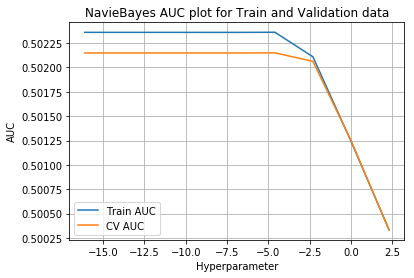

In [35]:
#With NB
model2 = MultinomialNB
model2_NB_hp = tune_Models_clf(clf=model2,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                y_cv=y_cv[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                clf_name="NavieBayes",
                multi_label=True)

### Observations:
#### 1. On observing the hyperparameter plots for LR and SVM in model-2, it is very clear that both are suffering form low-bais and high variance. Hence here for model-2 we can try with RandomForest algorithm. But for this objective of compitation prediciting sub-target labels are not required, as in the final metric this result is not included, Hence ignoring this here.

#### 2. In this case also Navie Bayes is not performing well

### Model-3

100%|██████████| 10/10 [31:00<00:00, 265.81s/it]


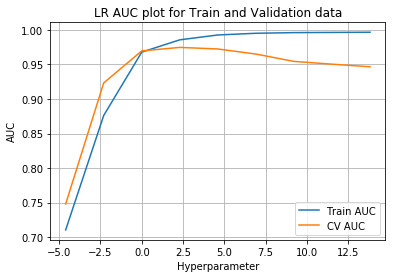

In [36]:
#With LR
model3 = LogisticRegression
model3_LR_hp = tune_Models_clf(clf=model3,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                y_cv=y_cv[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                clf_name="LR",
                multi_label=True)

In [54]:
model3 =LogisticRegression(C=1,class_weight='balanced')
model3_LR= fit_best_Model_clf(clf=model3,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                               y_train=y_train[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                               y_test=y_test[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                               multi_label=True)
print("AUC on Test data using LR as model3: {}".format(model3_LR[1]))

print("AUC on Train data using LR as model3: {}".format(model3_LR[0]))

AUC on Test data using LR as model3: 0.9661670853389234
AUC on Train data using LR as model3: 0.967743465472692


100%|██████████| 10/10 [1:57:28<00:00, 827.12s/it]


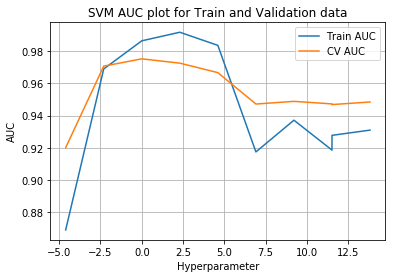

In [37]:
#With SVM
model3 = LinearSVC
model3_LR_hp = tune_Models_clf(clf=model3,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                y_cv=y_cv[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                clf_name="SVM",
                multi_label=True)

In [60]:
model3 =LinearSVC(C=1,class_weight='balanced')
model3_SVM= fit_best_Model_clf(clf=model3,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                               y_train=y_train[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                               y_test=y_test[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                               multi_label=True)
print("AUC on Test data using SVM as model3: {}".format(model3_SVM[1]))

print("AUC on Train data using SVM as model3: {}".format(model3_SVM[0]))

AUC on Test data using SVM as model3: 0.9744281099499675
AUC on Train data using SVM as model3: 0.9865194899269003


100%|██████████| 9/9 [06:39<00:00, 44.33s/it]


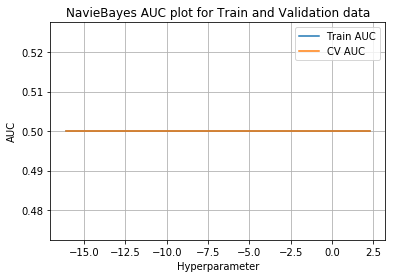

In [38]:
#With NB
model3 = MultinomialNB
model3_NB_hp = tune_Models_clf(clf=model3,
                x_train=X_train_TFIDF,
                x_cv=X_cv_TFIDF,
                y_train=y_train[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                y_cv=y_cv[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                clf_name="NavieBayes",
                multi_label=True)

In [59]:
model3_results=pd.DataFrame(zip([model3_LR[1],model3_SVM[1]],[model3_LR[0],model3_SVM[0]]),
              columns=['Test_AUC','Train_AUC'],index=['LR',"SVM"])
model3_results

,Test_AUC,Train_AUC
LR,0.966167,0.967743
SVM,0.974428,0.986519


In [61]:
model1_results

,Test_AUC,Train_AUC
LR,0.828861,0.869523
SVM,0.890898,0.911296


#### Choosing optimal models and combaining all

#### model1 = LinearSVC(C=1)

#### model2 = LinearSVC(C=1)
         
#### model3 = LinearSVC(C=1)

In [83]:
model1 =LinearSVC(C=1)

model2 =LinearSVC(C=1)

model3 =LinearSVC(C=1,class_weight='balanced')

model1_Preds = fit_best_Model_clf(clf=model1,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                               y_train=y_train['target'],
                               y_test=y_test['target'],
                               multi_label=False,
                               return_predictions=True)

model2_Preds = fit_best_Model_clf(clf=model2,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                              y_train=y_train[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                               y_test=y_test[['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']],
                               multi_label=True,
                               return_predictions=True)



model3_Preds = fit_best_Model_clf(clf=model3,
                               x_train=X_train_TFIDF,
                               x_test=X_test_TFIDF,
                               y_train=y_train[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                               y_test=y_test[['male','female','homosexual_gay_or_lesbian','christian','jewish','muslim','black','white','psychiatric_or_mental_illness']],
                               multi_label=True,
                               return_predictions=True)

test_toxic_AUC = final_AUC_metric(y_true=y_test, y_predicted=np.hstack([model1_Preds[1].reshape(-1,1),model2_Preds[1],model3_Preds[1]]),
                                   final_AUC_metric_alone=False)

In [86]:
test_toxic_AUC[1]

,SUB,BPSN,BNSP
male,0.611498,0.643545,0.615087
female,0.605644,0.645401,0.607738
homosexual_gay_or_lesbian,0.58749,0.631229,0.60281
christian,0.57022,0.646891,0.57065
jewish,0.596355,0.642394,0.599821
muslim,0.603895,0.638225,0.611974
black,0.58764,0.641961,0.593764
white,0.596914,0.643565,0.602252
psychiatric_or_mental_illness,0.616447,0.641485,0.620635
Mp,0.596423,0.641543,0.601748


In [87]:
test_toxic_AUC[0]

0.6212974338900007

#### Summary:
1. In the 1st method no model did well on multilabel classification.
2. In the 2nd method, even though individual AUC are good, the "final_toxic_AUC" value is only 62% .
